# Bag of Words Meets Bags of Popcorn

![bow](https://kaggle2.blob.core.windows.net/competitions/kaggle/3971/logos/front_page.png)

* https://www.kaggle.com/c/word2vec-nlp-tutorial

### [자연 언어 처리 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%9E%90%EC%97%B0_%EC%96%B8%EC%96%B4_%EC%B2%98%EB%A6%AC)

* 자연 언어 처리(自然言語處理) 또는 자연어 처리(自然語處理)는 인간이 발화하는 언어 현상을 기계적으로 분석해서 컴퓨터가 이해할 수 있는 형태로 만드는 자연 언어 이해 혹은 그러한 형태를 다시 인간이 이해할 수 있는 언어로 표현하는 제반 기술을 의미한다. (출처 : 위키피디아)

### 자연어처리(NLP)와 관련 된 캐글 경진대회
* [Sentiment Analysis on Movie Reviews | Kaggle](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)
* [Toxic Comment Classification Challenge | Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
* [Spooky Author Identification | Kaggle](https://www.kaggle.com/c/spooky-author-identification)


## 튜토리얼 개요
### 파트1 
* 초보자를 대상으로 기본 자연어 처리를 다룬다.

### 파트2, 3
* Word2Vec을 사용하여 모델을 학습시키는 방법과 감정분석에 단어 벡터를 사용하는 방법을 본다.

* 파트3는 레시피를 제공하지 않고 Word2Vec을 사용하는 몇 가지 방법을 실험해 본다.

* 파트3에서는 K-means 알고리즘을 사용해 군집화를 해본다.

* 긍정과 부정 리뷰가 섞여있는 100,000만개의 IMDB  감정분석 데이터 세트를 통해 목표를 달성해 본다.


### 평가 - ROC 커브(Receiver-Operating Characteristic curve)
* TPR(True Positive Rate)과 FPR(False Positive Rate)을 각각 x, y 축으로 놓은 그래프
* 민감도 TPR 
    - 1인 케이스에 대해 1로 예측한 비율
    - 암환자를 진찰해서 암이라고 진단함
* 특이도 FPR
    - 0인 케이스에 대해 1로 잘못 예측한 비율
    - 암환자가 아닌데 암이라고 진단함
    
* X, Y가 둘 다 [0, 1] 범위이고 (0, 0)에서 (1, 1)을 잇는 곡선이다.
* ROC 커브의 및 면적이 1에 가까울 수록(왼쪽 꼭지점에 다가갈수록) 좋은 성능

* 참고 : 
    * [New Sight :: Roc curve, AUR(AUCOC), 민감도, 특이도](http://newsight.tistory.com/53)
    * [ROC의 AUC 구하기 :: 진화하자 - 어디에도 소속되지 않기](http://adnoctum.tistory.com/121)
    * [Receiver operating characteristic - Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
    
### Use Google's Word2Vec for movie reviews
* 자연어 텍스트를 분석해서 특정단어를 얼마나 사용했는지, 얼마나 자주 사용했는지, 어떤 종류의 텍스트인지 분류하거나 긍정인지 부정인지에 대한 감정분석, 그리고 어떤 내용인지 요약하는 정보를 얻을 수 있다.
* 감정분석은 머신러닝(기계학습)에서 어려운 주제로 풍자, 애매모호한 말, 반어법, 언어 유희로 표현을 하는데 이는 사람과 컴퓨터에게 모두 오해의 소지가 있다. 여기에서는 Word2Vec을 통한 감정분석을 해보는 튜토리얼을 해본다.
* Google의 Word2Vec은 단어의 의미와 관계를 이해하는 데 도움
* 상당수의 NLP기능은 nltk모듈에 구현되어 있는데 이 모듈은 코퍼스, 함수와 알고리즘으로 구성되어 있다.
* 단어 임베딩 모형 테스트 : [Korean Word2Vec](http://w.elnn.kr/search/)

### BOW(bag of words)
* 가장 간단하지만 효과적이라 널리쓰이는 방법
* 장, 문단, 문장, 서식과 같은 입력 텍스트의 구조를 제외하고 각 단어가 이 말뭉치에 얼마나 많이 나타나는지만 헤아린다.
* 구조와 상관없이 단어의 출현횟수만 세기 때문에 텍스트를 담는 가방(bag)으로 생각할 수 있다.
* BOW는 단어의 순서가 완전히 무시 된다는 단점이 있다. 예를 들어 의미가 완전히 반대인 두 문장이 있다고 하다.
    - `it's bad, not good at all.` 
    - `it's good, not bad at all.` 
* 위 두 문장은 의미가 전혀 반대지만 완전히 동일하게 반환된다.
* 이를 보완하기 위해 n-gram을 사용하는 데 BOW는 하나의 토큰을 사용하지만 n-gram은 n개의 토큰을 사용할 수 있도록 한다.

* [Bag-of-words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)

# 파트 1

NLP는?
NLP(자연어처리)는 텍스트 문제에 접근하기 위한 기술집합이다.
이 튜토리얼에서는 IMDB 영화 리뷰를 로딩하고 정제하고 간단한 BOW(Bag of Words) 모델을 적용하여 리뷰가 추천인지 아닌지에 대한 정확도를 예측한다.


### 시작하기 전에
이 튜토리얼은 파이썬으로 되어 있으며, NLP에 익숙하다면 파트2 로 건너뛰어도 된다.

In [1]:
import pandas as pd

# QUOTE_MINIMAL (0), QUOTE_ALL (1), 
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).
train = pd.read_csv('data/labeledTrainData.tsv', 
                    header=0, delimiter='\t', quoting=3)
train.shape

(25000, 3)

In [2]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [3]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [5]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [6]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [7]:
# html 태그가 섞여있기 때문에 이를 정제해줄 필요가 있음
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

### 데이터 정제
* 뷰티풀숩이 설치되지 않았다면 우선 설치해 준다.
```
!pip install BeautifulSoup4
```

In [8]:
# 설치 및 버전확인
!pip show BeautifulSoup4

Name: beautifulsoup4
Version: 4.6.0
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: /Users/corazzon/codes/jupyter/lib/python3.6/site-packages
Requires: 


In [9]:
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [10]:
# 정규표현식을 사용해서 특수문자를 제거
import re
# 소문자와 대문자가 아닌 것은 공백으로 대체한다.
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [11]:
# 모두 소문자로 변환한다.
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()
words[:10]

['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

### Stopword Removal 불용어 제거

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to"또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.


### NLTK data 설치 
* http://corazzon.github.io/nltk_data_install 

In [12]:
import nltk
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [13]:
# stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

### 스테밍(어간추출, 형태소 분석)
출처 : [어간 추출 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%96%B4%EA%B0%84_%EC%B6%94%EC%B6%9C)


* 어간 추출(語幹 抽出, 영어: stemming)은 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
* "message", "messages", "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
* stemming(형태소 분석): NLTK는 2개의 형태소 분석기를 제공한다. 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적이다. 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산한다.

In [14]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [15]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [16]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]
# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다. 동음이의어가 문맥에 따라 다른 의미를 갖는데 
<pre>
1) *배*가 맛있다. 
2) *배*를 타는 것이 재미있다. 
3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
</pre>
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다. <br/>
레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다.


* 하지만 이 튜토리얼에서는 Stemming과 Lemmatizing을 소개만 해서 stemming 코드를 별도로 추가하였다.


# 문자열 처리
*  위에서 간략하게 살펴본 내용을 바탕으로 문자열을 처리해 본다.

In [17]:
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )

In [18]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [19]:
num_reviews = train['review'].size
num_reviews
# clean_train_reviews = []
# 캐글 튜토리얼에는 range가 xrange로 되어있지만 
# 여기에서는 python3를 사용하기 때문에 range를 사용했다.

# for i in range(0, num_reviews):
#     clean_train_reviews.append( review_to_words(train['review'][i]))

25000

In [20]:
# 하지만 위 코드는 어느 정도 실행이 되고 있는지 알 수가 없어서
# 5000개 단위로 상태를 찍도록 개선했다.
# 그리고 코드를 좀 더 간결하게 하기 위해 for loop를 사용하는 
# 대신 apply를 사용하도록 개선

# clean_train_reviews = []
# for i in range(0, num_reviews):
#     if (i + 1)%5000 == 0:
#         print('Review {} of {} '.format(i+1, num_reviews))
#     clean_train_reviews.append(review_to_words(train['review'][i]))
    
%time train['review_clean'] = train['review'].apply(review_to_words) 

CPU times: user 1min 33s, sys: 3.53 s, total: 1min 37s
Wall time: 1min 52s


In [21]:
clean_train_reviews = train['review_clean']

### 워드 클라우드
- 단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
- 단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는 게 더 의미 있기 때문에 큰 정보를 얻기는 어렵다.

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

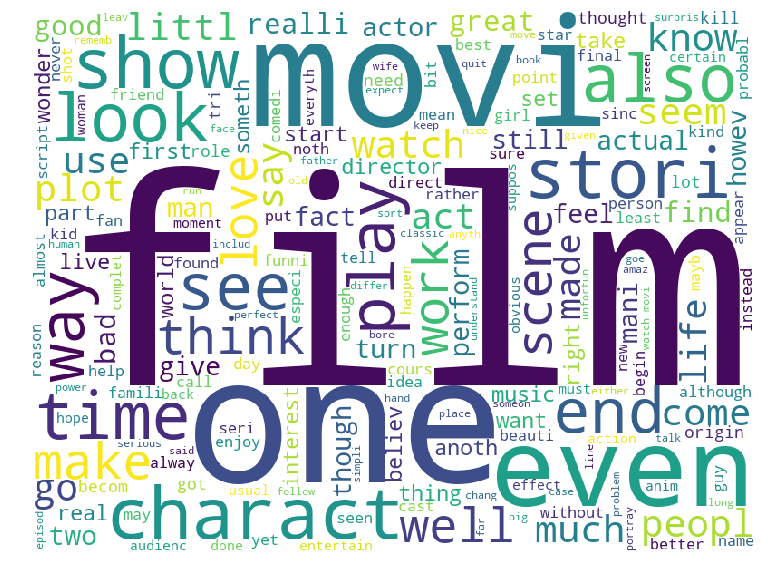

CPU times: user 32.6 s, sys: 2.19 s, total: 34.8 s
Wall time: 42.2 s


In [23]:
# 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(train['review_clean']))

In [24]:
# 단어 수
train['num_words'] = train['review_clean'].apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = train['review_clean'].apply(lambda x: len(set(str(x).split())))

In [25]:
x = train['review_clean'][0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

Text(0.5,1,'리뷰별 단어 수, 고유한 단어 수 분포')

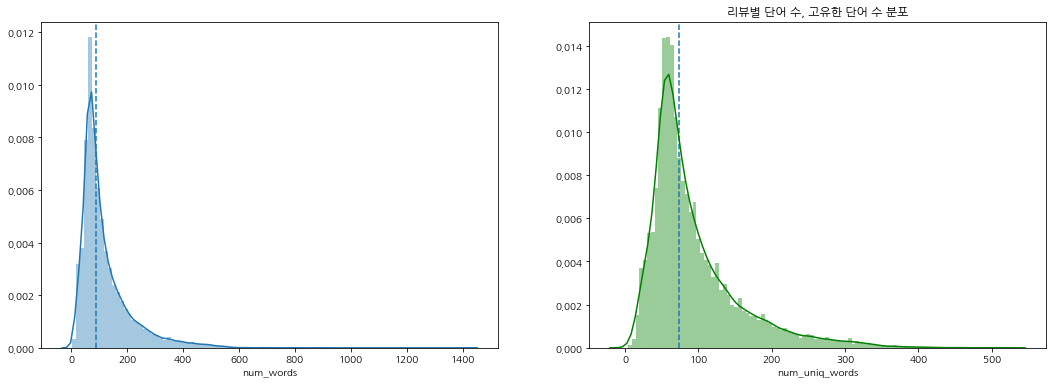

In [26]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)

axes[0].axvline(train['num_words'].median(), linestyle='dashed')
sns.distplot(train['num_words'], bins=100, ax=axes[0])

axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
plt.title('리뷰별 단어 수, 고유한 단어 수 분포')

### 사이킷런을 통해 피처 생성
#### CountVectorizer
* 정규표현식을 사용해 토큰을 추출한다.
* 모두 소문자로 변환시키기 때문에 good, Good, gOod이 모두 같은 특성이 된다.
* 의미없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
* min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# 튜토리얼과 다르게 파라메터 값을 수정
# 파라메터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [28]:
# 속도 개선을 위해 파이프라인을 사용하도록 개선
# 참고 : https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])  

In [29]:
%time train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

CPU times: user 50.6 s, sys: 2.61 s, total: 53.3 s
Wall time: 58.3 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

In [30]:
train_data_features.shape

(25000, 20000)

In [31]:
vocab = vectorizer.get_feature_names()
vocab[:10]

['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [32]:
# 벡터화 된 피처를 확인해 봄
import numpy as np
dist = np.sum(train_data_features, axis=0)
    
for tag, count in zip(vocab, dist):
    print(count, tag)
    
pd.DataFrame(dist, columns=vocab)

[[26 48 22 ..., 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [33]:
pd.DataFrame(train_data_features[:100].toarray(), columns=vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
%time forest = forest.fit(train_data_features, train['sentiment'])

CPU times: user 1min 56s, sys: 2.8 s, total: 1min 59s
Wall time: 60 s


In [36]:
# 테스트 데이터를 불러옴

# QUOTE_MINIMAL (0), QUOTE_ALL (1), 
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).
test = pd.read_csv('data/testData.tsv', 
                   header=0, delimiter='\t', quoting=3)
test.shape

(25000, 2)

In [37]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [38]:
# # train 데이터와 마찬가지로 데이터를 정제함
# clean_test_reviews = []

# def clean_review_text(review_data):
#     num_reviews = len(review_data)
#     for i in range(0, num_reviews):
#         if (i + 1) % 5000 == 0:
#             print('Review {} of {}'.format(i+1, num_reviews))
#         clean_review = review_to_words(review_data[i])
#         clean_test_reviews.append(clean_review)

# 위의 코드를 아래 코드로 개선 
# 하지만 멀티스레딩이 되지 않아 속도가 올래 걸리기 때문에 아래 코드로 다시 개선
# %time test['review_clean'] = test['review'].apply(review_to_words)
# clean_test_reviews = test['review_clean']
# CPU times: user 1min 12s, sys: 5.23 s, total: 1min 17s
# Wall time: 1min 18s

In [39]:
# 참고 : https://gist.github.com/yong27/7869662
# http://www.racketracer.com/2016/07/06/pandas-in-parallel/
from multiprocessing import Pool

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))
    
%time clean_test_reviews = apply_by_multiprocessing(test['review'], review_to_words, workers=4)    

CPU times: user 205 ms, sys: 238 ms, total: 442 ms
Wall time: 1min 19s


In [40]:
# 제대로 정제가 되었는지 첫 번째 데이터로 확인해 봄
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [41]:
# 테스트 데이터를 벡터화 함
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [42]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
# 벡터화 된 단어로 숫자가 문서에서 등장하는 횟수를 나타낸다
test_data_features[5][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [44]:
# 벡터화 하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
# vocab = vectorizer.get_feature_names()
vocab[8], vocab[2558], vocab[2559], vocab[2560]

('abc', 'charact person', 'charact play', 'charact plot')

In [46]:
result = forest.predict(test_data_features)

In [47]:
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})

In [48]:
output.to_csv('data/tutorial_1_BOW_model.csv', index=False, quoting=3)

In [49]:
output['sentiment'].value_counts()

0    12509
1    12491
Name: sentiment, dtype: int64

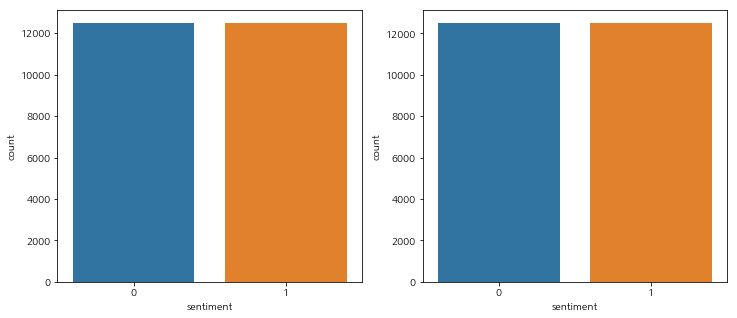

In [50]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

첫 번째 제출을 할 준비가 되었다.
리뷰를 다르게 정리하거나 'Bag of Words' 표현을 위해 다른 수의 어휘 단어를 선택하거나 포터 스테밍 등을 시도해 볼 수 있다.
다른 데이터세트로 NLP를 시도해 보려면 로튼 토마토(Rotten Tomatoes)를 해보는 것도 좋다.

* 로튼 토마토 데이터 셋을 사용하는 경진대회 : [Sentiment Analysis on Movie Reviews | Kaggle](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)

In [51]:
# uni-gram 사용 시 캐글 점수 0.84476
print(436/578)
# tri-gram 사용 시 캐글 점수 0.84608
print(388/578)
# 어간추출 후 캐글 점수 0.84780
print(339/578)
# 랜덤포레스트의 max_depth = 5 로 지정하고
# CountVectorizer의 tokenizer=nltk.word_tokenize 를 지정 후 캐글 점수 0.81460
print(546/578)
# 랜덤포레스트의 max_depth = 5 는 다시 None으로 변경
# CountVectorizer max_features = 10000개로 변경 후 캐글 점수 0.85272
print(321/578)
# CountVectorizer의 tokenizer=nltk.word_tokenize 를 지정 후 캐글 점수 0.85044
print(326/578)
# CountVectorizer max_features = 10000개로 변경 후 캐글 점수 0.85612
print(305/578)
# 0.85884
print(296/578)

0.754325259515571
0.671280276816609
0.5865051903114187
0.9446366782006921
0.5553633217993079
0.5640138408304498
0.527681660899654
0.5121107266435986
